### Initialization cell: run once on notebook start up

In [88]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit

# Find the index from xvals of the value which is closest to xval.  If more than one exact match, returns the lowest index
# xvals should be spaced less than 66e6 apart
def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

# Find the x value corresponding to the max y value from the sets xvals, yvals in the range from xmin to xmax
def findmax(xvals,yvals,xmin,xmax): 
    xminindex = -666
    xmaxindex = -666
    # Find the indexes of the limits using findindex function
    xminindex = findindex(xvals,xmin)
    xmaxindex = findindex(xvals,xmax)
    # Find the max y value and the x value which is at the same index
    maxy = max(yvals[xminindex:xmaxindex])
    maxx = xvals[np.where(yvals==maxy)[0][0]]
    #maxx = 0
    return maxx,maxy #return peak as x,y coordinate tuple

def histtoplot(histdata,bins): #data to be binned, number of bins
    graph = []
    newbins=[]
    count,bincount,bars=plt.hist(histdata,bins)
    
    for i in range(len(bincount)-1):
        newbins.append(bincount[i]/2+bincount[i+1]/2)
    graph.append(newbins)
    graph.append(count)
    graph.append(len(count))
    graph.append(int(sum(count)))
    return graph #a list of 4 elements: a list of x values, a list of y values, the number of data points, & the integral of the distribution

def gaus(x, normalization,location, stdev):
    u = (x - location)/stdev
    return normalization* np.exp(-0.5*u**2)


### User Inputs

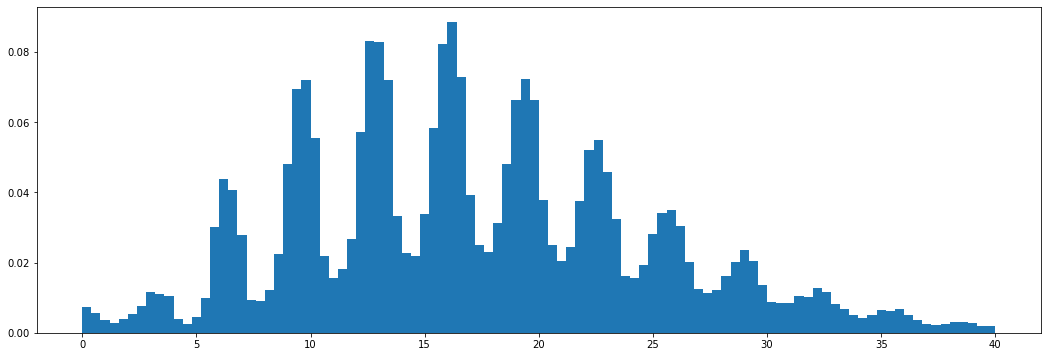

In [70]:
#    Load a dataset of peak-to-peak values which you wish to bin into a finger spectrum

with open('../fcal_project_jay/raw_data/Algorithm_Test.pkl', 'rb') as f:
    p2ps = pickle.load(f)

counts,binedges,bars=plt.hist(p2ps.eval("ch2_P2P_fit"),100,range=(0,40),density=True)
#plt.xlim(17,18)
bincenters = binedges[:-1]/2+binedges[1:]/2
T = bincenters[-1] - bincenters[0] #total integration period
N = len(bincenters) #number of points



hires = 6 #high resolution at low frequencies, set to at least 2;
          #gives a factor of $hires finer frequency sampling, but with a factor of $hires smaller frequency window

hires_start = 0.25 #start high resolution requency scan at frequency=hiresoff/T/hires -- set to 0 for standard lowpass filter


hiresoff=int(np.floor(hires_start*T*hires))

In [6]:
p2ps

,ch1_chisq,ch1_P2P_raw,ch1_time_raw,ch1_P2P_base,ch1_time_base,ch1_P2P_smooth,ch1_time_smooth,ch1_P2P_fit,ch1_time_fit,ch2_chisq,ch2_P2P_raw,ch2_time_raw,ch2_P2P_base,ch2_time_base,ch2_P2P_smooth,ch2_time_smooth,ch2_P2P_fit,ch2_time_fit
0,23.711149,913.3,68.8801,873.673333,68.8801,873.666400,68.8801,882.438778,68.834009,2.103067,34.5,86.8486,28.057333,87.2392,26.785333,87.2392,26.093302,87.618928
1,3.377518,966.5,66.6803,950.081333,66.6803,950.080400,66.6803,949.797017,66.615173,1.820615,28.6,86.2442,23.464000,86.3227,22.890000,86.2442,22.143206,86.235832
2,2.865443,964.5,68.8147,950.239333,69.0101,950.247067,68.8147,949.995610,68.770352,1.213202,16.5,124.0870,13.024000,125.2590,11.851733,124.6730,9.445646,96.282833
3,2.864910,964.6,69.5041,950.372000,69.5041,950.364133,69.3088,949.774131,69.286862,1.219550,37.2,90.2070,31.680667,90.4023,30.662533,90.2070,29.503976,89.761251
4,4.501465,963.8,67.7063,949.559333,67.9017,949.548933,67.7063,949.418050,67.693778,4.629159,24.7,150.6800,21.162000,150.6800,17.638400,83.5264,16.046725,78.084847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50986,2.774294,964.9,68.9137,950.232667,68.9137,950.218000,68.9137,949.664914,68.773605,1.945593,35.4,87.2728,29.121333,88.2494,28.254933,87.8587,26.537965,88.336292
50987,1.813161,965.1,69.0283,950.623333,69.0283,950.612800,69.0283,950.171055,68.973158,1.528282,22.4,88.3641,18.768667,88.7546,17.566267,88.3641,16.225685,88.687451
50988,1.805881,965.6,66.7793,950.138667,66.7793,950.130267,66.7793,950.221559,66.574655,1.900771,25.4,184.9770,21.448000,184.9770,20.088400,87.3219,19.543691,87.263172
50989,2.454367,966.2,67.8116,950.393333,68.0069,950.388533,67.8116,950.226926,67.795778,1.130119,19.6,95.7408,15.256000,108.2410,13.633600,95.7408,12.463940,91.710157


In [71]:

FFTs = np.zeros([3,N//2]) #Fourier frequencies, amplitudes, and phases
FFTshr = np.zeros([3,N//2]) #high res

# The DFT is always symmetric about its midpoint.
# Frequencies above the midpoint are below the Nyquist criterion and does not represent real frequencies.
for f in range(0,N//2): #iterate over frequencies
    A = 0
    Ahr = 0
    for d in range(N): #iterate over data points
        A += counts[d] * np.exp(-1j*2*np.pi*d*f/N) #integrate at frequencies f/N, A = a +ib for the fourier expansion f(t) = a*cos(wt)+bsin(wt)
        Ahr += counts[d] * np.exp(-1j*2*np.pi*d*(f+hiresoff)/N/hires)
    
    FFTs[0][f] = f/T #frequency
    FFTs[1][f] = la.norm(A)/N*2 #amplitude, factor of 2 to account for symmetry of DFT
    FFTs[2][f] = np.arctan2(np.imag(A),np.real(A)) #phase
    
    FFTshr[0][f] = (f+hiresoff)/T/hires #hires frequency
    FFTshr[1][f] = la.norm(Ahr)/N/hires*2 #hires amplitude
    FFTshr[2][f] = np.arctan2(np.imag(Ahr),np.real(Ahr)) #hires phase

#Inverse Fourier transform
invFT = np.zeros(N,complex)
invFThr = np.zeros(N,complex)

for d in range(N): #iterate over data points
    for f in range(N//2): #iterate over frequencies
        invFT[d] += FFTs[1][f] * np.exp(2j*np.pi*d/N*f+1j*FFTs[2][f])
        invFThr[d] += FFTshr[1][f] * np.exp(2j*np.pi*d/N*(f+hiresoff)/hires+1j*FFTshr[2][f])
#take real part and add the DC offset back
ReinvFT = np.real(invFT) + counts[0] - np.real(invFT[0])
ReinvFThr = np.real(invFThr) + counts[0] - np.real(invFThr[0])

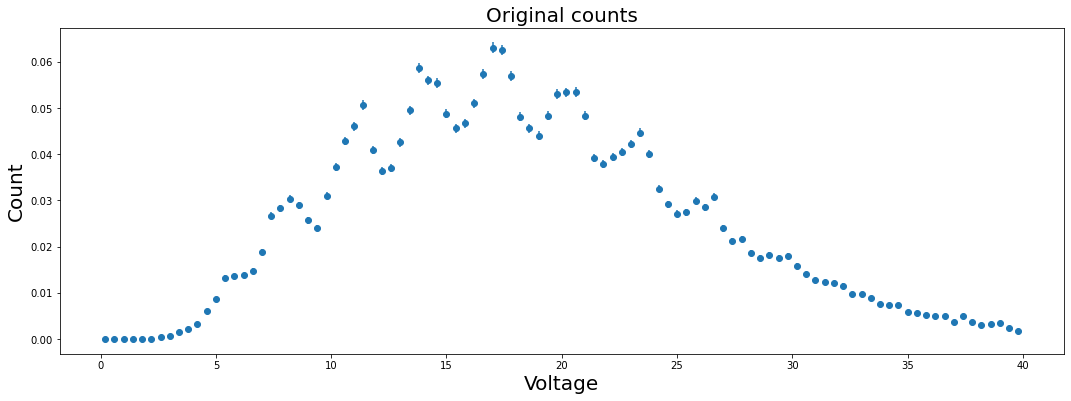

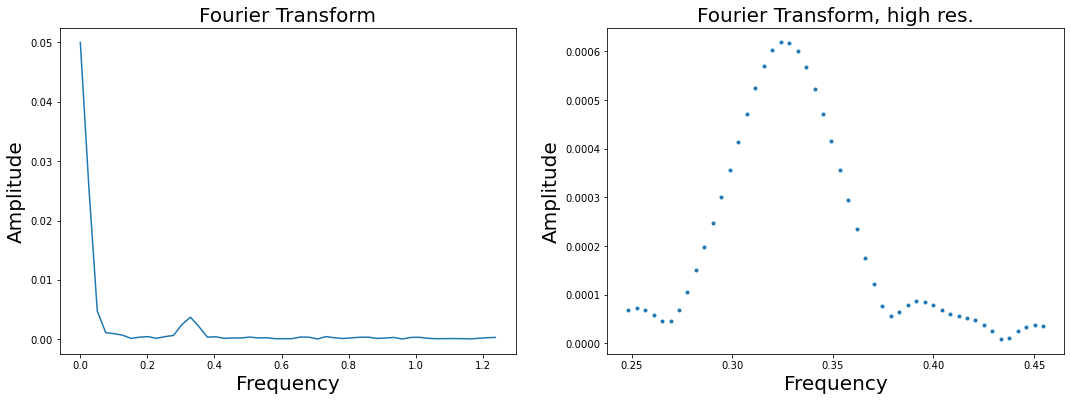

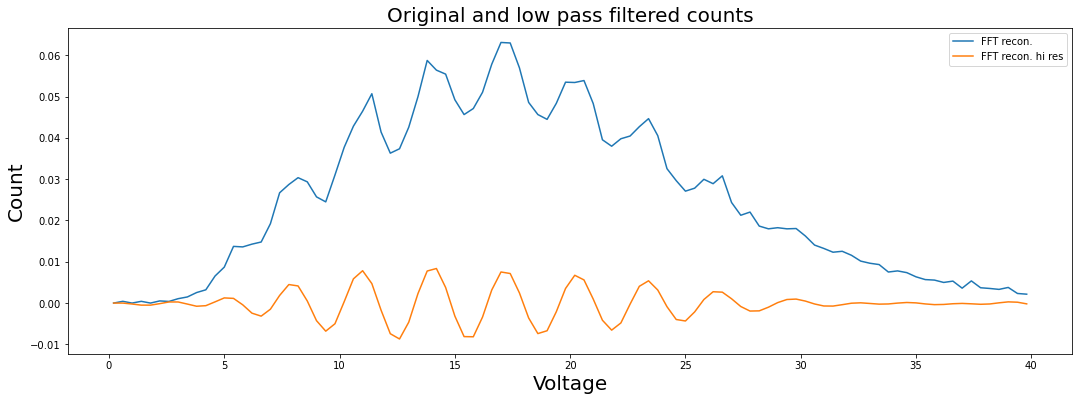

In [69]:
#make plots
plt.rcParams["figure.figsize"] = (18,6)
plt.errorbar(bincenters,y=counts,yerr=np.sqrt(counts/np.size(p2ps,0)),fmt='o')

plt.title("Original counts", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Count", size=20)
plt.show()

fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(FFTs[0],FFTs[1],"-")
ax[0].set_title("Fourier Transform", size=20)
ax[0].set_xlabel("Frequency", size=20)
ax[0].set_ylabel("Amplitude", size=20)

ax[1].plot(FFTshr[0],FFTshr[1],".")
ax[1].set_title("Fourier Transform, high res.", size=20)
ax[1].set_xlabel("Frequency", size=20)
ax[1].set_ylabel("Amplitude", size=20)
plt.show()

plt.plot(bincenters,ReinvFT,label="FFT recon.")
plt.plot(bincenters,ReinvFThr,label="FFT recon. hi res")
plt.legend()
plt.title("Original and low pass filtered counts", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Count", size=20)
plt.show()

In [26]:
#Find the maxima in the high resolution frequency scan
xmax,ymax=findmax(FFTshr[0],FFTshr[1],0.1,1)  #note: last two inputs to this function define the frequency bounds within which it searches for the maxima
uncertainty = (FFTshr[0][1]-FFTshr[0][0])/xmax

print(f"maxima found in the given range at x={xmax:.2f}, y={ymax:.2f}")
print(f'This corresponds to a peak every {1/xmax:.3f} mV/pixel +/- {uncertainty*1/xmax:.3f}')
#print(1/(max_x+0.00011))

maxima found in the given range at x=0.31, y=4.71
This corresponds to a peak every 3.184 mV/pixel +/- 0.040


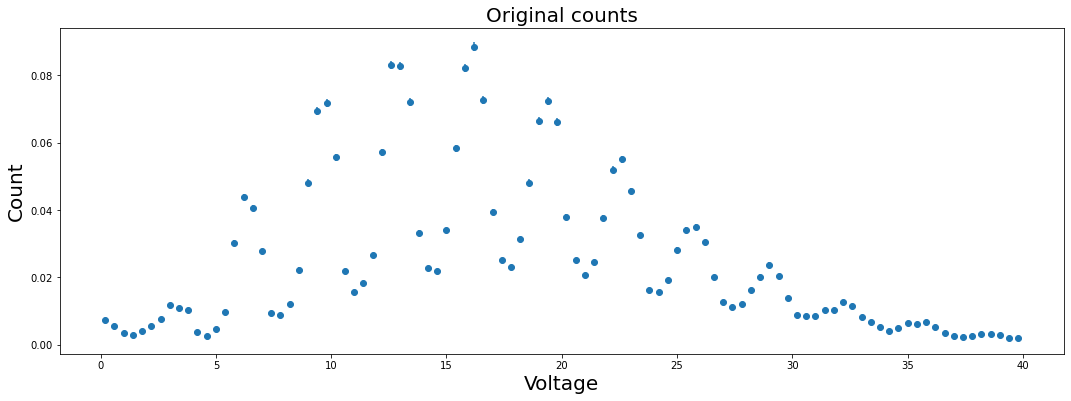

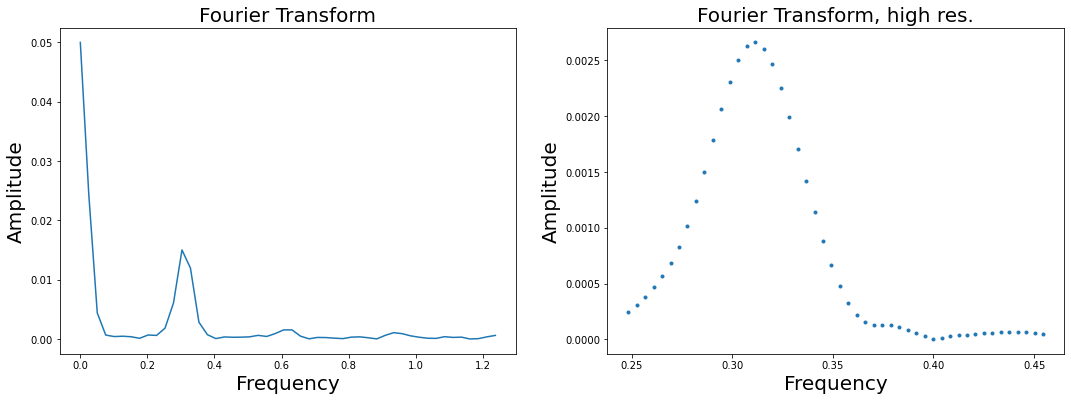

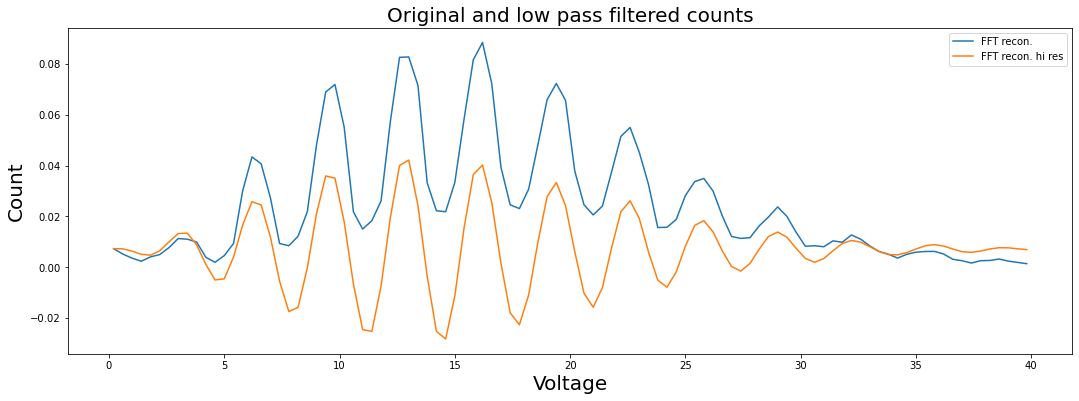

In [72]:
#make plots
plt.rcParams["figure.figsize"] = (18,6)
plt.errorbar(bincenters,y=counts,yerr=np.sqrt(counts/np.size(p2ps,0)),fmt='o')

plt.title("Original counts", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Count", size=20)
plt.show()

fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(FFTs[0],FFTs[1],"-")
ax[0].set_title("Fourier Transform", size=20)
ax[0].set_xlabel("Frequency", size=20)
ax[0].set_ylabel("Amplitude", size=20)

ax[1].plot(FFTshr[0],FFTshr[1],".")
ax[1].set_title("Fourier Transform, high res.", size=20)
ax[1].set_xlabel("Frequency", size=20)
ax[1].set_ylabel("Amplitude", size=20)
plt.show()

plt.plot(bincenters,ReinvFT,label="FFT recon.")
plt.plot(bincenters,ReinvFThr,label="FFT recon. hi res")
plt.legend()
plt.title("Original and low pass filtered counts", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Count", size=20)
plt.show()

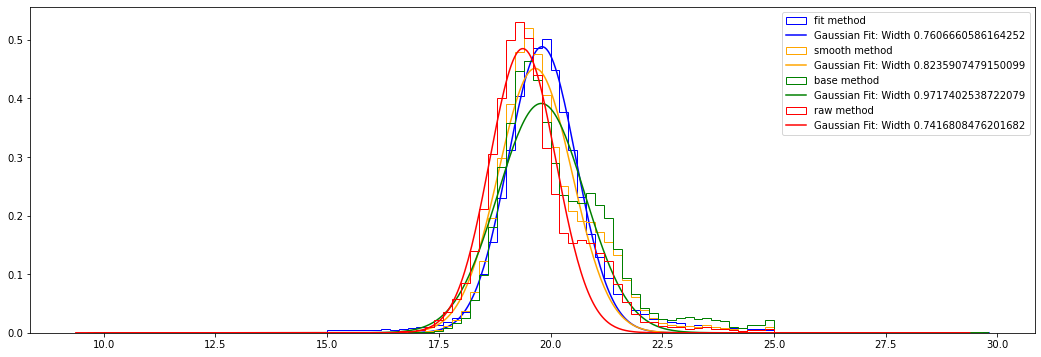

In [103]:
methods = ["fit","smooth","base","raw"]
colors=["blue","orange","green","red","purple","cyan", "black"]
for i in range(len(methods)):
    count,binedges,bars=plt.hist(p2ps.eval(f"ch2_time_{methods[i]}-ch1_time_{methods[i]}"),50,range=(15,25),density=True,color = colors[i],histtype="step",label = f"{methods[i]} method")
    bincenters = binedges[1:]/2+binedges[:-1]/2
    coeff, covar = curve_fit(gaus, bincenters, count,p0=(1,20,1))
    plt.plot(np.linspace(coeff[1]-10,coeff[1]+10,500),gaus(np.linspace(coeff[1]-10,coeff[1]+10,500),*coeff),label=f"Gaussian Fit: Width {coeff[2]}",color=colors[i])
plt.legend()